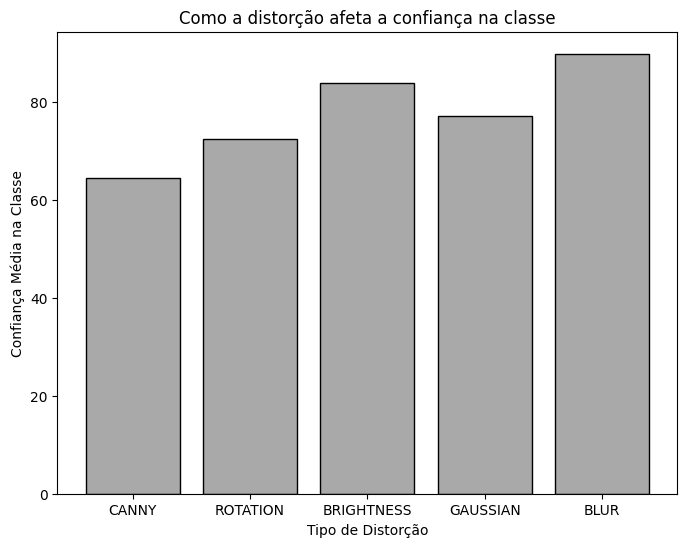

Gráfico salvo: gráficos/confiança_por_distorção.png


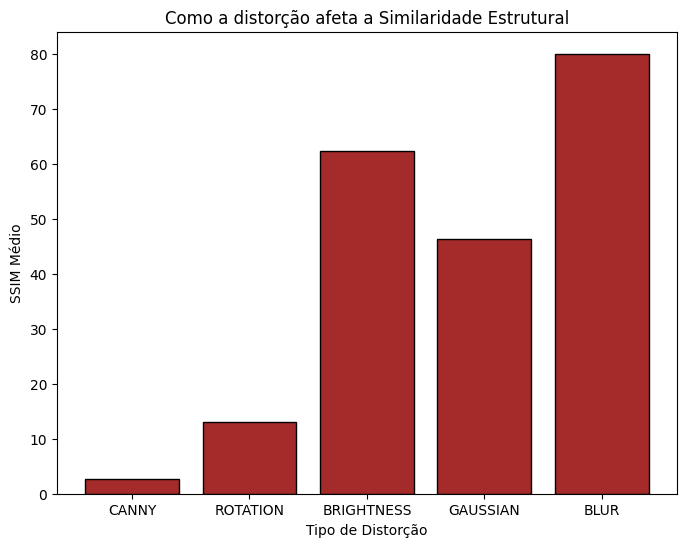

Gráfico salvo: gráficos/ssim_por_distorção.png


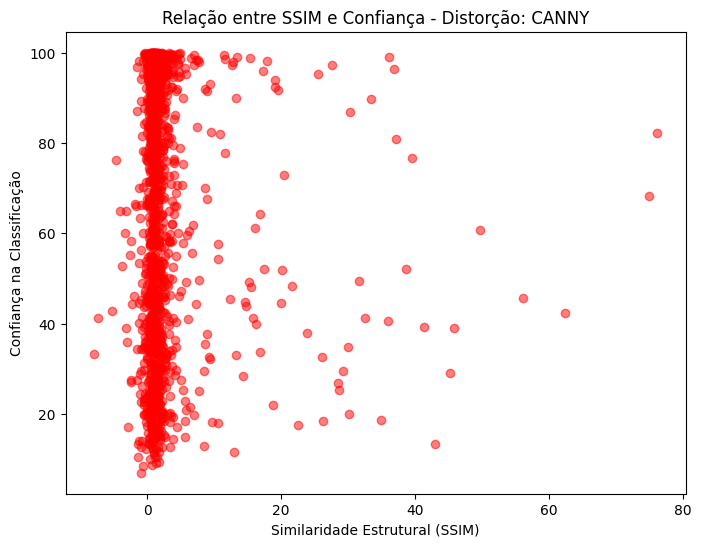

Gráfico salvo: gráficos/ssim_vs_confiança_CANNY.png


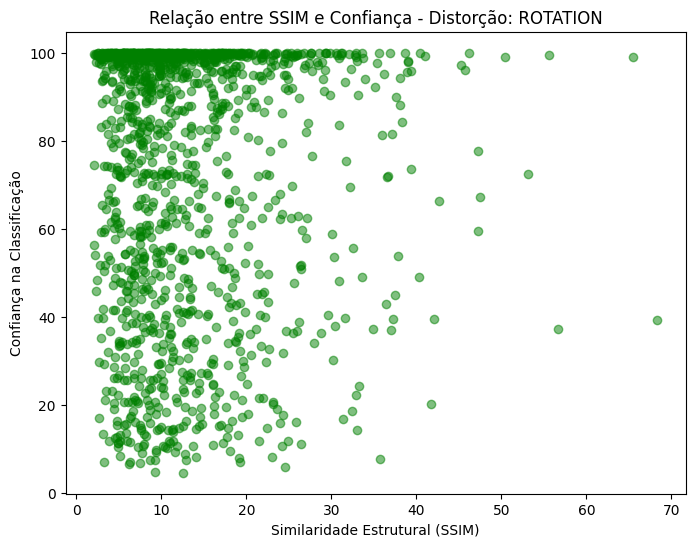

Gráfico salvo: gráficos/ssim_vs_confiança_ROTATION.png


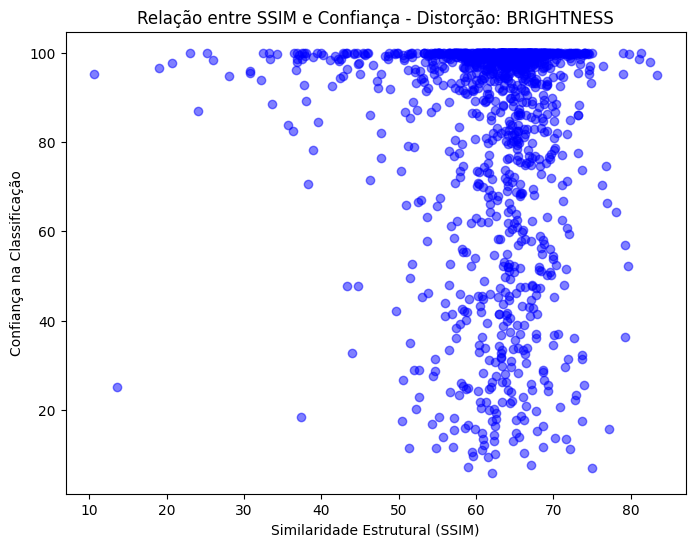

Gráfico salvo: gráficos/ssim_vs_confiança_BRIGHTNESS.png


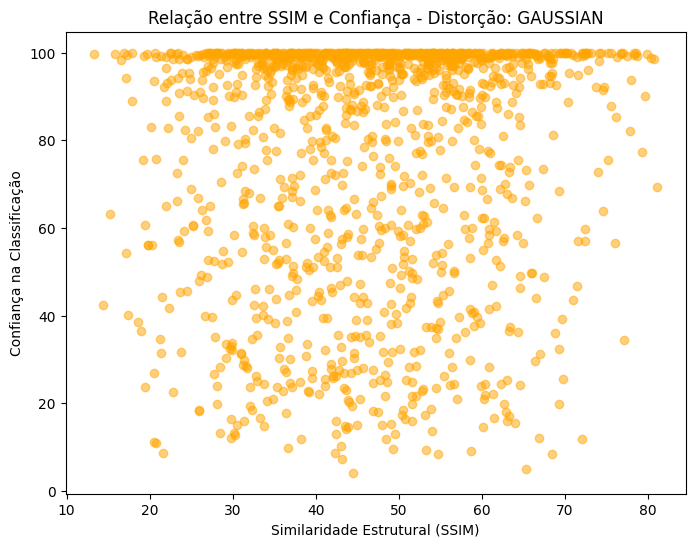

Gráfico salvo: gráficos/ssim_vs_confiança_GAUSSIAN.png


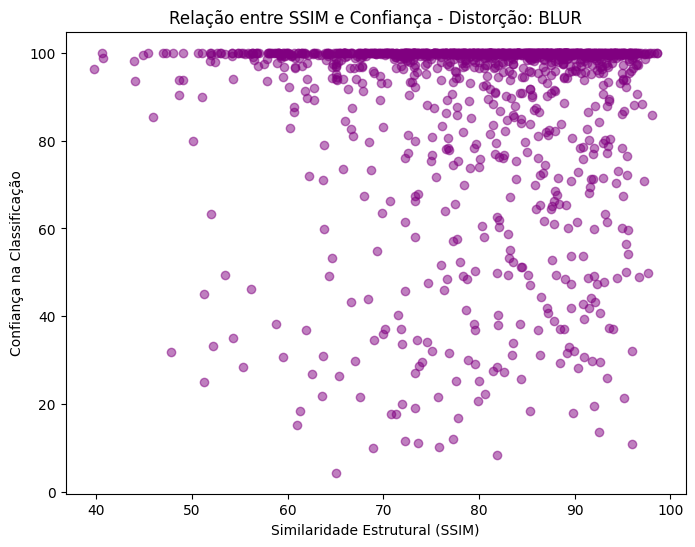

Gráfico salvo: gráficos/ssim_vs_confiança_BLUR.png
Dataframe atualizado com proporção e intensidade média das bordas de Canny.


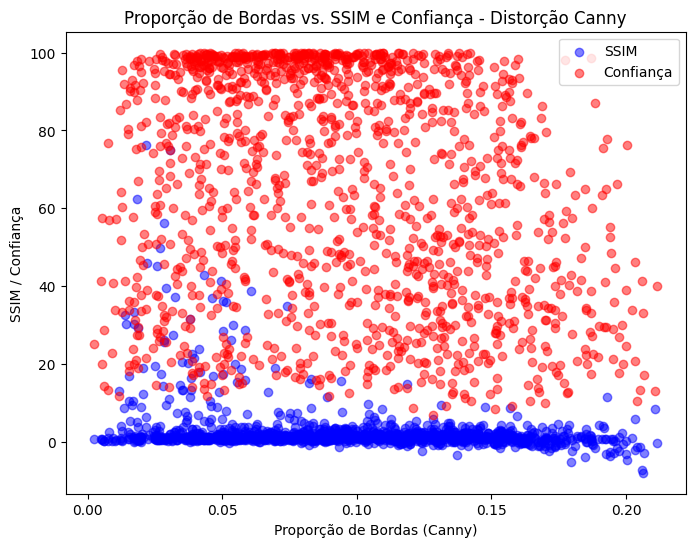

Gráfico salvo: gráficos/proporcao_bordas_vs_ssim_confianca.png


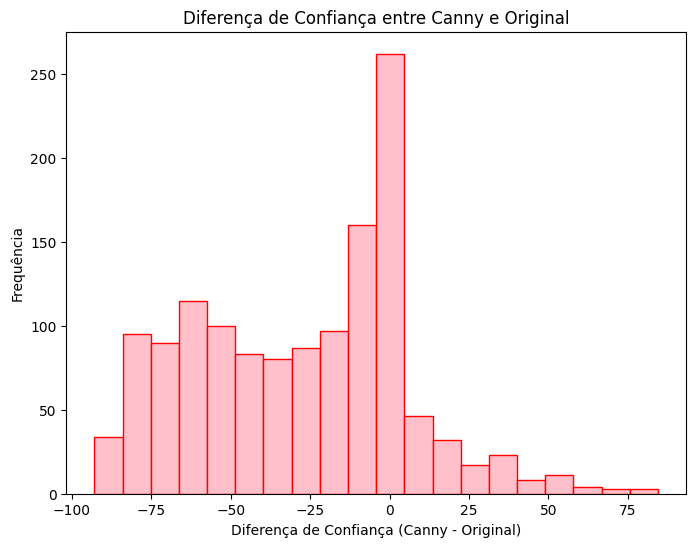

Gráfico salvo: gráficos/diferenca_confianca_canny_original.png


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import cv2

def extract_max_class_confidence(class_list_str):
    try:
        class_list = ast.literal_eval(class_list_str)
        max_class = max(class_list, key=lambda x: x[2])
        return max_class[1], max_class[2] 
    except Exception:
        return None, None

def calculate_edge_ratio(edge_image):
    edge_pixels = np.sum(edge_image == 255)
    total_pixels = edge_image.size
    return edge_pixels / total_pixels

if not os.path.exists("gráficos"):
    os.makedirs("gráficos")

df = pd.read_csv('distorcoes/distorcoes-data.csv', sep=";")

df["ORIGINAL_CLASS_LABEL"], df["ORIGINAL_CONFIDENCE"] = zip(*df["ORIG_CLASSES"].apply(extract_max_class_confidence))

distortions = ["CANNY", "ROTATION", "BRIGHTNESS", "GAUSSIAN", "BLUR"]
for distortion in distortions:
    class_col = f"{distortion}_CLASSES"
    df[f"{distortion}_CLASS_LABEL"], df[f"{distortion}_CONFIDENCE"] = zip(*df[class_col].apply(extract_max_class_confidence))

distortion_columns = {
    "CANNY": ("CANNY_SSIM", "CANNY_CONFIDENCE"),
    "ROTATION": ("ROTATION_SSIM", "ROTATION_CONFIDENCE"),
    "BRIGHTNESS": ("BRIGHTNESS_SSIM", "BRIGHTNESS_CONFIDENCE"),
    "GAUSSIAN": ("GAUSSIAN_SSIM", "GAUSSIAN_CONFIDENCE"),
    "BLUR": ("BLUR_SSIM", "BLUR_CONFIDENCE"),
}

confidence_means = {distortion: df[f"{distortion}_CONFIDENCE"].mean() for distortion in distortions}
plt.figure(figsize=(8, 6))
plt.bar(confidence_means.keys(), confidence_means.values(), color="darkgray", edgecolor="black")
plt.title("Como a distorção afeta a confiança na classe")
plt.xlabel("Tipo de Distorção")
plt.ylabel("Confiança Média na Classe")
plt.savefig("gráficos/confiança_por_distorção.png")
plt.show()
plt.close()
print("Gráfico salvo: gráficos/confiança_por_distorção.png")

ssim_means = {distortion: df[f"{distortion}_SSIM"].mean() for distortion in distortions}
plt.figure(figsize=(8, 6))
plt.bar(ssim_means.keys(), ssim_means.values(), color="brown", edgecolor="black")
plt.title("Como a distorção afeta a Similaridade Estrutural")
plt.xlabel("Tipo de Distorção")
plt.ylabel("SSIM Médio")
plt.savefig("gráficos/ssim_por_distorção.png")
plt.show()
plt.close()
print("Gráfico salvo: gráficos/ssim_por_distorção.png")

colors = ["red", "green", "blue", "orange", "purple"]
for i, (distortion, (ssim_col, confidence_col)) in enumerate(distortion_columns.items()):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[ssim_col], df[confidence_col], alpha=0.5, color=colors[i])
    plt.xlabel("Similaridade Estrutural (SSIM)")
    plt.ylabel("Confiança na Classificação")
    plt.title(f"Relação entre SSIM e Confiança - Distorção: {distortion}")
    plt.savefig(f"gráficos/ssim_vs_confiança_{distortion}.png")
    plt.show()
    plt.close()
    print(f"Gráfico salvo: gráficos/ssim_vs_confiança_{distortion}.png")

# Adicionando Análises para a Distorção Canny: Proporção e Intensidade das Bordas

df['CANNY_EDGE_RATIO'] = None
df['CANNY_EDGE_INTENSITY'] = None

for index, row in df.iterrows():
    file_path = row['FILE_PATH']
    image_path = file_path.replace("imagenette2/", "").replace(".JPEG", "")
    image_file = image_path.replace("train/n01440764/", "").replace("val/n01440764/", "")
    canny_image_path = f"distorcoes/{image_path}/{image_file}.JPEG_dist_canny.JPEG"
    
    canny_image = cv2.imread(canny_image_path, cv2.IMREAD_GRAYSCALE)
    edge_ratio = calculate_edge_ratio(canny_image)
    edge_intensity = np.mean(canny_image[canny_image == 255])
    
    df.at[index, 'CANNY_EDGE_RATIO'] = edge_ratio
    df.at[index, 'CANNY_EDGE_INTENSITY'] = edge_intensity

# Salvar o DataFrame atualizado
df.to_csv("distorcoes/distorcoes-data.csv", sep=";")
print("Dataframe atualizado com proporção e intensidade média das bordas de Canny.")

# Análise: Proporção de Bordas vs. SSIM e Confiança
plt.figure(figsize=(8, 6))
plt.scatter(df['CANNY_EDGE_RATIO'], df['CANNY_SSIM'], alpha=0.5, label="SSIM", color="blue")
plt.scatter(df['CANNY_EDGE_RATIO'], df['CANNY_CONFIDENCE'], alpha=0.5, label="Confiança", color="red")
plt.xlabel("Proporção de Bordas (Canny)")
plt.ylabel("SSIM / Confiança")
plt.legend()
plt.title("Proporção de Bordas vs. SSIM e Confiança - Distorção Canny")
plt.savefig("gráficos/proporcao_bordas_vs_ssim_confianca.png")
plt.show()
plt.close()
print("Gráfico salvo: gráficos/proporcao_bordas_vs_ssim_confianca.png")

# Análise: Comparação de Confiança Canny vs. Original
df['CONFIDENCE_DIFF_CANNY_ORIGINAL'] = df['CANNY_CONFIDENCE'] - df['ORIGINAL_CONFIDENCE']
plt.figure(figsize=(8, 6))
plt.hist(df['CONFIDENCE_DIFF_CANNY_ORIGINAL'], bins=20, color="pink", edgecolor="red")
plt.title("Diferença de Confiança entre Canny e Original")
plt.xlabel("Diferença de Confiança (Canny - Original)")
plt.ylabel("Frequência")
plt.savefig("gráficos/diferenca_confianca_canny_original.png")
plt.show()
plt.close()
print("Gráfico salvo: gráficos/diferenca_confianca_canny_original.png")
